<a href="https://colab.research.google.com/github/Vaishnavii-27/crop-prediction-/blob/main/crop_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import datetime
import os

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Crop_recommendation.csv to Crop_recommendation.csv


In [3]:
df = pd.read_csv('Crop_recommendation.csv')
df

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,coffee


In [4]:
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

In [5]:
encoder = LabelEncoder()
labels = encoder.fit_transform(labels)
num_classes = len(np.unique(labels))

# Convert the features and labels to PyTorch tensors
features = torch.tensor(features, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Normalize the features to have zero mean and unit variance
mean = features.mean(dim=0)
std = features.std(dim=0)
features = (features - mean) / std

In [6]:
features[0]

tensor([ 1.0686, -0.3445, -0.1017, -0.9354,  0.4726,  0.0433,  1.8099])

In [11]:
os.makedirs("D:/Vaishnavi/CROP_PREDICTOR/normalization", exist_ok=True)
np.savez("D:/Vaishnavi/CROP_PREDICTOR/normalization.npz", mean=mean, std=std)

In [12]:
with open("D:/Vaishnavi/CROP_PREDICTOR/encoder.pkl", "wb") as file:
    pickle.dump(encoder, file)

In [13]:
# Define a custom PyTorch dataset to wrap the features and labels
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

In [14]:
dataset = CustomDataset(features, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [15]:
class Net_64_128_64(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Net_64_128_64, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, num_classes)


    def forward(self, x):
        x = F.selu(self.fc1(x))
        x = F.selu(self.fc2(x))
        x = F.selu(self.fc3(x))
        x = self.fc4(x)
        return F.softmax(x)

In [16]:
# Define the network hyperparameters
input_size = 7
num_classes = 22

# Initialize the network
net = Net_64_128_64(input_size, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

# Train the network
train_losses = []
val_losses = []
EPOCH = 100
train_accuracies = []
val_accuracies = []

In [17]:
for epoch in range(EPOCH):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_dataset):
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_dataset)
    train_losses.append(train_loss)
    with torch.no_grad():
        val_loss = 0.0
        for inputs, labels in val_dataset:
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_dataset)
        val_losses.append(val_loss)
    if epoch % 10 == 9:
        print(f'Epoch {epoch+1}/{EPOCH}: train loss: {train_loss:.4f} val loss: {val_loss:.4f}')

print('Finished training')

/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Epoch 10/100: train loss: 2.2061 val loss: 2.2033
Epoch 20/100: train loss: 2.1845 val loss: 2.1880
Epoch 30/100: train loss: 2.1792 val loss: 2.1821
Epoch 40/100: train loss: 2.1766 val loss: 2.1798
Epoch 50/100: train loss: 2.1741 val loss: 2.1791
Epoch 60/100: train loss: 2.1726 val loss: 2.1812
Epoch 70/100: train loss: 2.1715 val loss: 2.1785
Epoch 80/100: train loss: 2.1705 val loss: 2.1801
Epoch 90/100: train loss: 2.1696 val loss: 2.1780
Epoch 100/100: train loss: 2.1698 val loss: 2.1784
Finished training


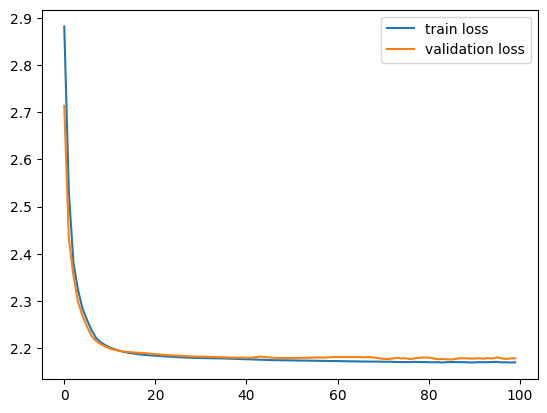

In [19]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

In [20]:
model_name = str(datetime.datetime.now()).replace(' ','-').replace(':','-').replace('.','-') + '.hdf5'
file_name = f'./model/{model_name}'
if not os.path.exists('./model/'):
    os.mkdir('./model/')
    print("creating model dir")

creating model dir


In [21]:
torch.save(net.state_dict(), file_name)

In [25]:
model = Net_64_128_64(input_size,num_classes)
model.load_state_dict(torch.load(file_name))

<All keys matched successfully>

In [26]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_dataset:
        outputs = model(inputs)
        predicted = outputs.argmax()
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        # print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the train: {accuracy:.2f}%')

/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Accuracy of the network on the train: 99.55%


In [27]:
# Calculate the accuracy
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_dataset:
        # print("Inputs:",inputs)
        outputs = model(inputs)
        predicted = outputs.argmax()
        # print(predicted, labels)
        total += 1
        correct += (predicted == labels)
        dec_labels= encoder.inverse_transform(np.array([predicted,labels]))
        # print(f"pred: {dec_labels[0]}, real: {dec_labels[1]}")
        print(predicted)

accuracy = 100 * correct / total
print(f'Accuracy of the network on the validation: {accuracy:.2f}%')

/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecate

tensor(8)
tensor(0)
tensor(1)
tensor(17)
tensor(1)
tensor(16)
tensor(7)
tensor(8)
tensor(12)
tensor(19)
tensor(13)
tensor(11)
tensor(10)
tensor(1)
tensor(7)
tensor(1)
tensor(9)
tensor(6)
tensor(10)
tensor(8)
tensor(14)
tensor(21)
tensor(14)
tensor(2)
tensor(20)
tensor(10)
tensor(0)
tensor(6)
tensor(21)
tensor(12)
tensor(10)
tensor(21)
tensor(1)
tensor(7)
tensor(11)
tensor(4)
tensor(12)
tensor(20)
tensor(9)
tensor(5)
tensor(2)
tensor(3)
tensor(11)
tensor(15)
tensor(13)
tensor(17)
tensor(5)
tensor(19)
tensor(17)
tensor(6)
tensor(21)
tensor(15)
tensor(2)
tensor(0)
tensor(20)
tensor(10)
tensor(0)
tensor(2)
tensor(15)
tensor(10)
tensor(13)
tensor(14)
tensor(10)
tensor(18)
tensor(16)
tensor(21)
tensor(9)
tensor(1)
tensor(18)
tensor(18)
tensor(6)
tensor(2)
tensor(16)
tensor(17)
tensor(20)
tensor(4)
tensor(14)
tensor(19)
tensor(5)
tensor(15)
tensor(18)
tensor(18)
tensor(15)
tensor(16)
tensor(20)
tensor(9)
tensor(12)
tensor(17)
tensor(0)
tensor(1)
tensor(10)
tensor(10)
tensor(5)
tensor(2)
tenso

/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)
/tmp/ipython-input-744636719.py:15: UserWarning: Implicit dimension choice for softmax has been deprecate